# HWIV

Bixuan LIU

## I. NN Model for 1-dimensional time series data
In this section, I constructed an NN model with 1 hidden layer and 5 nodes to forecast Number of Unemployed (umply) in Luxembourg. And compare the results with the ARIMA model in HWII.

### 1. Define model class

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### 2. Initialize the model

In [2]:
input_size = 1  # One-dimensional time series data
hidden_size = 5  # Number of nodes in the hidden layer
output_size = 1  # Output size (regression)

model = SimpleNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3. Train the model

In [3]:
# Import data
import pandas as pd

# Read the Excel file into a DataFrame
df = pd.read_excel("HWIV_data_liu.xlsx")
df.rename(columns={'Time period': 'date', '9. Number of Unemployed': 'umply', '10. Active Population': 'pop'}, inplace=True)

print(df)

          date         umply            pop
0   1995-01-01   4868.757781  171547.891390
1   1995-02-01   4808.390434  171880.830559
2   1995-03-01   4703.403744  172197.741094
3   1995-04-01   4365.696555  171821.691070
4   1995-05-01   4168.846510  172111.474364
..         ...           ...            ...
339 2023-04-01  15330.000000  308689.287139
340 2023-05-01  15188.000000  308891.139093
341 2023-06-01  15333.000000  309476.907263
342 2023-07-01  16111.000000  307174.983768
343 2023-08-01  16056.000000  306380.562733

[344 rows x 3 columns]


In [4]:
# Convert the data into yearly growth rates
df['umply_gr'] = (df['umply'] - df['umply'].shift(12)) / df['umply'].shift(12)
df['pop_gr'] = (df['pop'] - df['pop'].shift(12)) / df['pop'].shift(12)

df_gr = df.loc[12:, ['date', 'umply_gr', 'pop_gr']].reset_index(drop=True)

print(df_gr)

          date  umply_gr    pop_gr
0   1996-01-01  0.068464  0.032177
1   1996-02-01  0.072416  0.029055
2   1996-03-01  0.053199  0.028199
3   1996-04-01  0.109018  0.031830
4   1996-05-01  0.107450  0.027202
..         ...       ...       ...
327 2023-04-01  0.074357  0.025367
328 2023-05-01  0.089058  0.024345
329 2023-06-01  0.124285  0.024101
330 2023-07-01  0.129883  0.023301
331 2023-08-01  0.134459  0.022038

[332 rows x 3 columns]


In [5]:
# Define the split point based on the length of the DataFrame
split_point = int(0.8 * len(df_gr))

# Split the time series data
train_data = df_gr['umply_gr'].iloc[:split_point]
test_data = df_gr['umply_gr'].iloc[split_point:]

# Convert the data to PyTorch tensors
train_data_torch = torch.FloatTensor(train_data.values).view(-1, 1)
test_data_torch = torch.FloatTensor(test_data.values).view(-1, 1)

In [6]:
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_data_torch)
    loss = criterion(outputs, train_data_torch)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.0594
Epoch [200/1000], Loss: 0.0211
Epoch [300/1000], Loss: 0.0132
Epoch [400/1000], Loss: 0.0089
Epoch [500/1000], Loss: 0.0048
Epoch [600/1000], Loss: 0.0020
Epoch [700/1000], Loss: 0.0007
Epoch [800/1000], Loss: 0.0003
Epoch [900/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0001


### 4. Test the model

In [7]:
with torch.no_grad():
    model.eval()

    # Initialize an array to store the forecasted values
    forecasted_values = []

    # Iterate through the test data one step at a time
    for i in range(len(test_data_torch) - 1):
        input_step = test_data_torch[:i+1]  # Include data up to the current step
        output_step = model(input_step)
        forecasted_values.append(output_step[-1].item())  # Take the last prediction

    # Convert the forecasted values to a PyTorch tensor
    forecasted_values_tensor = torch.Tensor(forecasted_values)

    # Reshape the forecasted values tensor to match the shape of the target data
    forecasted_values_tensor = forecasted_values_tensor.view(-1, 1)

    # Calculate the MSE for the one-step-ahead forecast
    mse_one_step_ahead = criterion(forecasted_values_tensor, test_data_torch[1:])
    print(f'\nMean Squared Error for One-Step-Ahead Forecast: {mse_one_step_ahead.item():.4f}')



Mean Squared Error for One-Step-Ahead Forecast: 0.0017


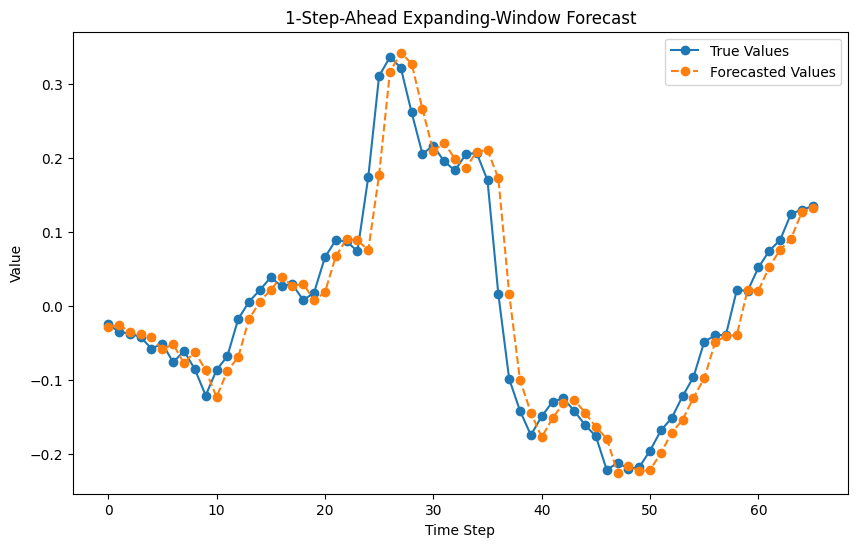

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data_torch[1:], label='True Values', marker='o')
plt.plot(forecasted_values, label='Forecasted Values', linestyle='dashed', marker='o')
plt.title('1-Step-Ahead Expanding-Window Forecast')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

### 5. Compare with ARIMA(4,0,0)
Note: For details about the ARIMA model, please refer to HWII_analysis_liu.rmd. Here I only quote the results.

RMSFE: 
NN model: 0.0017 ; 
ARIMA model: 0.069015

NN model has a smaller RMSFE. That's because comparing to ARIMA model, NN model is more able to capture the complex internal relations inside the time series. But it's computationally heavier. In this HW, I used 1000 epochs to reach this nice result. If the number of epochs decrease, the performance of NN model will surely be much worse.

## II. NN Model for multi-dimensional time series data
In this section, I constructed an NN model with again 1 hidden layer and 5 nodes to forecast Number of Unemployed (umply) and Active Population (pop) in Luxembourg. And compare the results with the VAR model in HWIII.

### 1. Initialize the model

In [39]:
input_size = 2  # Two-dimensional time series data
hidden_size = 5  # Number of nodes in the hidden layer
output_size = 2  # Output size (regression)

model = SimpleNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 2. Train the model

In [38]:
# Split the time series data
train_data = df_gr[['umply_gr', 'pop_gr']].iloc[:split_point]
test_data = df_gr[['umply_gr', 'pop_gr']].iloc[split_point:]

# Convert the data to PyTorch tensors
train_data_torch = torch.FloatTensor(train_data.values).view(-1, 2)
test_data_torch = torch.FloatTensor(test_data.values).view(-1, 2)

In [40]:
num_epochs = 10000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_data_torch)
    loss = criterion(outputs, train_data_torch)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1000/10000], Loss: 0.0019
Epoch [2000/10000], Loss: 0.0001
Epoch [3000/10000], Loss: 0.0001
Epoch [4000/10000], Loss: 0.0000
Epoch [5000/10000], Loss: 0.0000
Epoch [6000/10000], Loss: 0.0000
Epoch [7000/10000], Loss: 0.0000
Epoch [8000/10000], Loss: 0.0000
Epoch [9000/10000], Loss: 0.0000
Epoch [10000/10000], Loss: 0.0000


### 3. Test the model

In [41]:
with torch.no_grad():
    model.eval()

    # Initialize an array to store the forecasted values
    forecasted_values = []
    true_values = []

    # Iterate through the test data one step at a time
    for i in range(len(test_data_torch) - 1):
        input_step = test_data_torch[:i+1]  # Include data up to the current step
        output_step = model(input_step)
        forecasted_values.append(output_step[-1].tolist())  # Take the last prediction

    # Convert the forecasted values and true values to a PyTorch tensor
    forecasted_values = [list(row) for row in zip(*forecasted_values)]
    forecasted_umply_torch = torch.Tensor(forecasted_values[0])
    forecasted_pop_torch = torch.Tensor(forecasted_values[1])

    true_values = [list(row) for row in zip(*test_data_torch)]
    true_umply_torch = torch.Tensor(true_values[0])
    true_pop_torch = torch.Tensor(true_values[1])

    # Reshape the forecasted values tensor to match the shape of the target data
    forecasted_umply_torch = forecasted_umply_torch.view(-1, 1)
    forecasted_pop_torch = forecasted_pop_torch.view(-1, 1)
    true_umply_torch = true_umply_torch.view(-1, 1)
    true_pop_torch = true_pop_torch.view(-1, 1)

    # Calculate the MSE for the one-step-ahead forecast
    mse_umply = criterion(forecasted_umply_torch, true_umply_torch[1:])
    mse_pop = criterion(forecasted_pop_torch, true_pop_torch[1:])
    print(f'\nMean Squared Error for umply: {mse_umply.item():.4f}')
    print(f'\nMean Squared Error for pop: {mse_pop.item():.4f}')


Mean Squared Error for umply: 0.0016

Mean Squared Error for pop: 0.0000


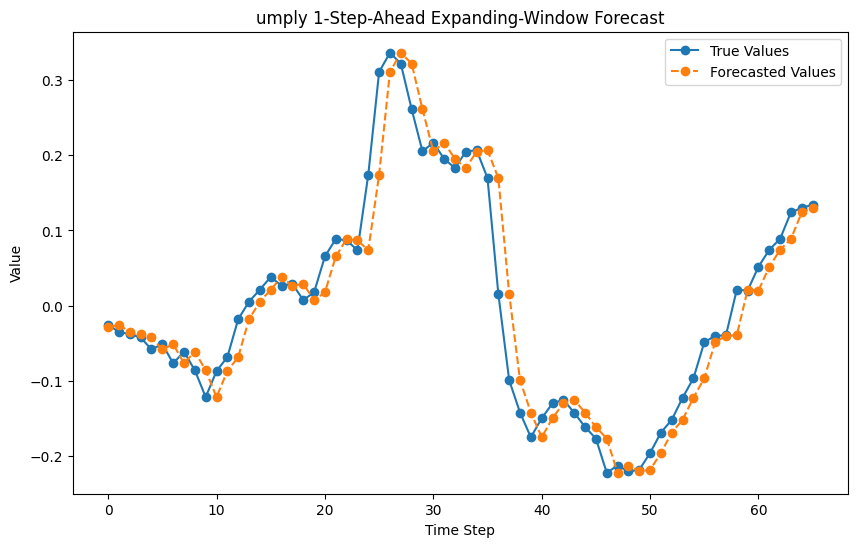

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(true_umply_torch[1:], label='True Values', marker='o')
plt.plot(forecasted_umply_torch, label='Forecasted Values', linestyle='dashed', marker='o')
plt.title('umply 1-Step-Ahead Expanding-Window Forecast')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

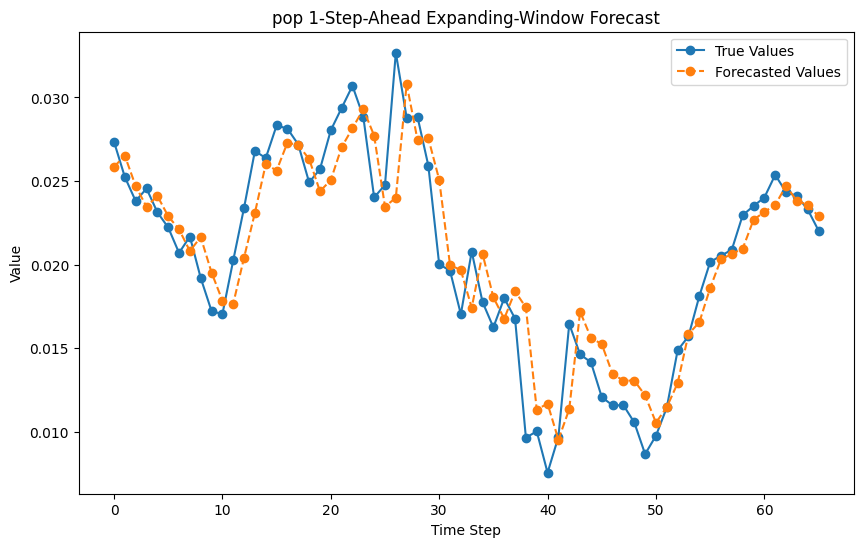

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(true_pop_torch[1:], label='True Values', marker='o')
plt.plot(forecasted_pop_torch, label='Forecasted Values', linestyle='dashed', marker='o')
plt.title('pop 1-Step-Ahead Expanding-Window Forecast')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

### 4. Compare with VAR(2)
Note: For details about the VAR(2) model, please refer to HWIII_analysis_liu.rmd. Here I only quote the results.

RMSFE: 

NN model: umply_gr: 0.0016, pop_gr: 0.0000;

ARIMA model: umply_gr: 0.1413, pop_gr: 0.0085.

NN model has again smaller RMSFEs. The reasons are similar to 1-dimensional data in Section I.

## III. BONUS: Estimate with LSTM
In this section, I estimate and forecast umply_gr with simpleLSTM.

### 1. Define model class

In [44]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

### 2. Initialize the model

In [45]:
# Instantiate the model, loss function, and optimizer
input_size = 1
hidden_size = 5
output_size = 1

model = SimpleLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3. Train the model

In [46]:
# Define the split point based on the length of the DataFrame
split_point = int(0.8 * len(df_gr))

# Split the time series data
train_data = df_gr['umply_gr'].iloc[:split_point]
test_data = df_gr['umply_gr'].iloc[split_point:]

# Convert the data to PyTorch tensors
train_data_torch = torch.FloatTensor(train_data.values).view(1, -1, 1)
test_data_torch = torch.FloatTensor(test_data.values).view(1, -1, 1)

In [47]:
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_data_torch)
    loss = criterion(outputs, train_data_torch)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

/Users/liubixuan/opt/anaconda3/envs/TS_NN/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 265, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Loss: 0.0152
Epoch [200/1000], Loss: 0.0149
Epoch [300/1000], Loss: 0.0149
Epoch [400/1000], Loss: 0.0149
Epoch [500/1000], Loss: 0.0149
Epoch [600/1000], Loss: 0.0149
Epoch [700/1000], Loss: 0.0149
Epoch [800/1000], Loss: 0.0149
Epoch [900/1000], Loss: 0.0149
Epoch [1000/1000], Loss: 0.0149


### 4. Test the model

In [48]:
with torch.no_grad():
    model.eval()

    # Initialize an array to store the forecasted values
    forecasted_values = []

    # Iterate through the test data one step at a time
    for i in range(len(test_data_torch)):
        input_step = test_data_torch[:i+1]  # Add both batch_size and sequence_length dimensions
        output_step = model(input_step)
        last_prediction = output_step[:, -1].item()  # Access the last prediction
        forecasted_values.append(last_prediction)

    # Convert the forecasted values to a PyTorch tensor
    forecasted_values_tensor = torch.Tensor(forecasted_values)

    # Reshape the forecasted values tensor to match the shape of the target data
    forecasted_values_tensor = forecasted_values_tensor.view(-1, 1)

    # Calculate the MSE for the one-step-ahead forecast
    mse_one_step_ahead = criterion(forecasted_values_tensor, test_data_torch)
    print(f'\nMean Squared Error for One-Step-Ahead Forecast: {mse_one_step_ahead.item():.4f}')


Mean Squared Error for One-Step-Ahead Forecast: 0.0222


/Users/liubixuan/opt/anaconda3/envs/TS_NN/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 67, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
